[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.0071
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 1.0072e-04
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 6.7444e-05
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 7.4350e-05
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 6.6814e-05
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 5.7428e-05
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 6.6363e-05
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 5.7147e-05
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 4.6555e-05
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 5.0956e-05
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


<ipython-input-10-86e216222205>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


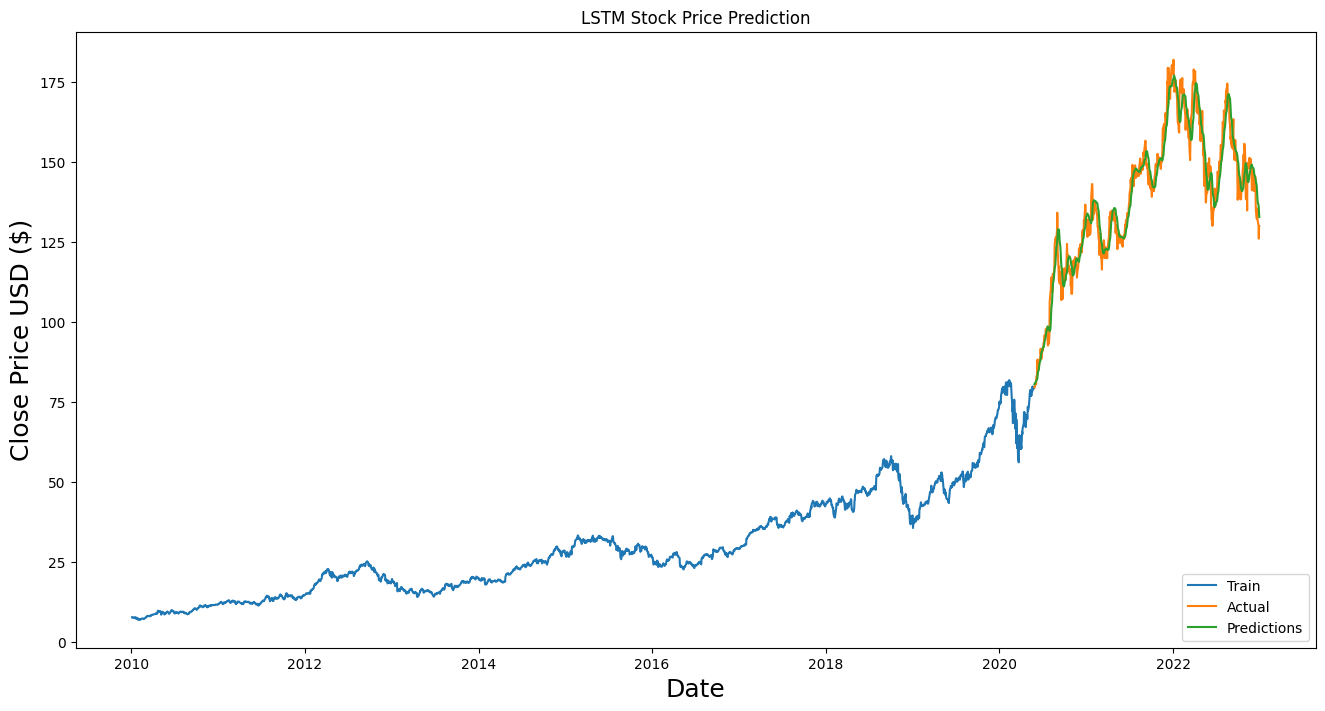

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# 1. Load Stock Data
stock_data = yf.download('AAPL', start='2010-01-01', end='2023-01-01')
stock_data.head()

# 2. Preprocess the Data
data = stock_data['Close'].values.reshape(-1, 1)

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into training and test sets (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]  # 60 time steps back

# 3. Prepare the Data for LSTM
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i - time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

# Create training and testing datasets
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 4. Build the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Train the Model
model.fit(X_train, y_train, batch_size=64, epochs=10)

# 6. Predict on Test Data
predictions = model.predict(X_test)

# Inverse scaling the predicted values to get them back to the original range
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Visualize the Results
train = stock_data[:train_size]
valid = stock_data[train_size:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()
